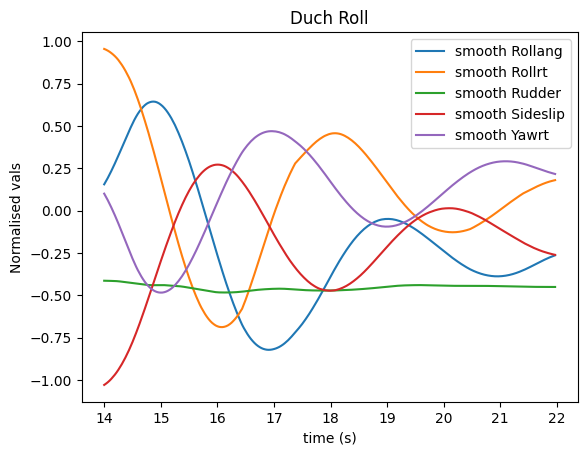

3.9999749019609623
(np.float64(0.22207252645084097), np.float64(4.041666666666667))
3.9999749019609623
(np.float64(0.20952576503352688), np.float64(4.093700000000354))
3.9999749019609623
(np.float64(0.13384554822806088), np.float64(4.093700000000354))
3.9999749019609623
(np.float64(0.13940904532114537), np.float64(4.062466666666903))


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy
from scipy import signal
from scipy.optimize import curve_fit
from ipywidgets import interact, widgets, fixed

# %matplotlib

duch_roll_data = scipy.io.loadmat("data_2024/Dutch-Roll.mat")
phugoid_data = scipy.io.loadmat("data_2024/Phugoid.mat")
roll_rub_data = scipy.io.loadmat("data_2024/Roll-Subs.mat")
spiral_data =  scipy.io.loadmat("data_2024/Spiral.mat")
SPO_data =  scipy.io.loadmat("data_2024/SPPO.mat")

duch_roll_data['Name'] = "Duch Roll"
phugoid_data['Name'] = "Phugoid"
roll_rub_data['Name'] = "Roll Subsidance"
spiral_data['Name'] = "Spiral"
SPO_data['Name'] = "SPO"

print_better = lambda stuff: print("\n".join(list(map(str, stuff))), "\n")

def secondOrd(t0,B,peak,period,zeta,t, phi=0):
    # t0,B,peak,period,zeta,t
    
    psim = np.atan(np.sqrt(1-zeta**2)/zeta)
    A = (peak - B)/(np.sqrt(1-zeta**2) * np.exp(-zeta*psim/np.sqrt(1-zeta**2)))

    omd = 2*np.pi/period
    omn = omd/np.sqrt(1-zeta**2)

    return A * np.exp(-zeta*omn*(t-t0)) * np.sin(omd*(t-t0)+phi)  +  B

# def secondOrd(t0,B,A,period,zeta,t):
#     psim = np.atan(np.sqrt(1-zeta**2)/zeta)
#     # A = (peak - B)/(np.sqrt(1-zeta**2) * np.exp(-zeta*psim/np.sqrt(1-zeta**2)))

#     omd = 2*np.pi/period
#     omn = omd/np.sqrt(1-zeta**2)

#     return A * np.exp(-zeta*omn*(t-t0)) * np.sin(omd*(t-t0))  +  B


def gauss_smooth(data, window_size=5, sigma=1):
    x = np.linspace(-1, 1, window_size)
    # print(data.shape, x.shape)
    kernel = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x/sigma)**2)
    kernel /= np.sum(kernel)
    padded_data = np.pad(data, window_size, "edge")
    # print(np.convolve(kernel, data[:, 0],  mode="same"))
    return np.convolve(kernel, padded_data,  mode="same")[window_size:-window_size]

def plot_all(data, smooth=True, exclude=None, start=0, end=None, norm=True):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    for key in data:
        if key not in  ["Time", "Name", '__header__', '__version__', '__globals__', "EAS", exclude]:
            if norm:
                norm_data = (data[key]-data[key][0])/np.max(np.abs(gauss_smooth((data[key]-data[key][0])[:, 0], window_size=30)))
                norm_data = norm_data[start_i:end_i].flatten()
            else:
                norm_data = data[key][start_i:end_i].flatten()
                
            if smooth:
                plt.plot(t, gauss_smooth(norm_data, window_size=30), label=f"smooth {key}")
            else:
                plt.plot(t, norm_data, label=key)
    plt.title(data["Name"])
    plt.legend()
    plt.ylabel("Normalised vals")
    plt.xlabel("time (s)")
    plt.show()

def plot_one(data, key, show=True, smooth=True, start=0, end=None, norm=True, sigma=1, window=50):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    
    if norm:
        norm_data = (data[key]-data[key][0])/np.max(np.abs(data[key]-data[key][0]))
    else:
        norm_data = data[key][:]
        
    t = t_true[start_i:end_i].flatten()
    norm_data = norm_data[start_i:end_i].flatten()

    plt.plot(t, norm_data, label=key)
    if smooth : plt.plot(t, gauss_smooth(norm_data, window_size=window, sigma=sigma), label=f"smooth {key}")
    if show:
        plt.title(key)
        plt.ylabel("Normalised val")
        plt.xlabel("time (s)")
        plt.legend()
        plt.show()

def plot_guess(data, key, p0, phi=0, start=0, end=None, show=True):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    plt.plot(t, secondOrd(start,*p0,t, phi=phi), label="simulated")
    if show:
        plt.legend()
        plt.show()

def freq_analysis(data, key, start=0, end=None, window_size=30, plot = True, show=True, debug=False, x_range=None, ignore_first=0):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    data_n = data[key][start_i:end_i].flatten()

    T= np.mean(np.diff(t, axis=0))
    fft_domain = np.fft.fft(gauss_smooth(data_n, window_size=window_size))
    freq = np.fft.fftfreq(len(fft_domain), d=T)
    n = ignore_first
    L = len(fft_domain)
    freq_out = np.mean(abs(freq[1+signal.find_peaks(abs(fft_domain[1:]), height=np.max(abs(fft_domain[1:])))[0]]))

    if debug:
        plt.plot(freq[1:], abs(fft_domain[1:]))
        if x_range is not None: plt.xlim(-x_range, x_range)
        if show: plt.show()

    if plot:
        plot_one(data, key, show=show, start=14, norm=False)

    return freq_out

def peak_method(data, key, start, end, smooth_window_size=30, sigma=1):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    data_n = data[key][start_i:end_i].flatten()

    peaks = signal.find_peaks(gauss_smooth(data_n, window_size=smooth_window_size, sigma=sigma))[0]
    peaks_neg = signal.find_peaks(-gauss_smooth(data_n, window_size=smooth_window_size, sigma=sigma))[0]

    comb_peaks = np.zeros(peaks.shape[0]+peaks_neg.shape[0], dtype=int)

    if peaks[0] > peaks_neg[0]:
        comb_peaks[::2] = peaks_neg
        comb_peaks[1::2] = peaks
    else:
        comb_peaks[::2] = peaks
        comb_peaks[1::2] = peaks_neg

    # print(comb_peaks)

    vals = np.zeros(comb_peaks.shape[0]-1)
    ts = np.zeros(comb_peaks.shape[0]-1)
    for i in range(comb_peaks.shape[0]-1):
        vals[i] = np.abs(data_n[comb_peaks[i]]-data_n[comb_peaks[i+1]])
        ts[i] = t[comb_peaks[i+1]] - t[comb_peaks[i]]
    # vals = np.abs(np.diff(data_n[comb_peaks]))
    tpr = vals[1:]/vals[:-1]
    tpr = np.mean(tpr)
    period = 2*np.mean(ts)
    # print(tpr)
    # print(2*np.mean(ts))

    zeta = 1/(np.sqrt(1+(np.pi/np.log(tpr))**2))
    # print(zeta)

    return zeta, period
    

def cost_func(sim_data, real_data):
    pass

def func(t, B, A, freq, phi, one_over_tau):
    return B + A*np.exp(-t*one_over_tau)*np.sin(2*np.pi*freq*t + phi)


# key = "EAS"
# gauss_smooth(duch_roll_data[key]/duch_roll_data[key][0])

plot_all(duch_roll_data, start=14, end=22)
print(1/freq_analysis(duch_roll_data, "Rollang", start=14, end=22, show=False, plot=False))
print(peak_method(duch_roll_data, "Rollang", start=14, end=22))

print(1/freq_analysis(duch_roll_data, "Rollrt", start=14, end=22, show=False, plot=False))
print(peak_method(duch_roll_data, "Rollrt", start=14, end=22))

print(1/freq_analysis(duch_roll_data, "Sideslip", start=14, end=22, show=False, plot=False))
print(peak_method(duch_roll_data, "Sideslip", start=14, end=22))

print(1/freq_analysis(duch_roll_data, "Yawrt", start=14, end=22, show=False, plot=False))
print(peak_method(duch_roll_data, "Yawrt", start=14, end=22))


In [3]:
print("Dutch-Roll")
print_better(scipy.io.whosmat("data_2024/Dutch-Roll.mat"))

print("Phugoid")
print_better(scipy.io.whosmat("data_2024/Phugoid.mat"))

print("Roll-Subs")
print_better(scipy.io.whosmat("data_2024/Roll-Subs.mat"))

print("Spiral")
print_better(scipy.io.whosmat("data_2024/Spiral.mat"))

print("SPPO")
print_better(scipy.io.whosmat("data_2024/SPPO.mat"))

Dutch-Roll
('EAS', (839, 1), 'double')
('Rollang', (839, 1), 'double')
('Rollrt', (839, 1), 'double')
('Rudder', (839, 1), 'double')
('Sideslip', (839, 1), 'double')
('Time', (839, 1), 'double')
('Yawrt', (839, 1), 'double') 

Phugoid
('Alpha', (3918, 1), 'double')
('Alt', (3918, 1), 'double')
('EAS', (3918, 1), 'double')
('Elevator', (3918, 1), 'double')
('Nz', (3918, 1), 'double')
('Ptchang', (3918, 1), 'double')
('Time', (3918, 1), 'double') 

Roll-Subs
('Aileron', (609, 1), 'double')
('EAS', (609, 1), 'double')
('Rollang', (609, 1), 'double')
('Rollrt', (609, 1), 'double')
('Time', (609, 1), 'double') 

Spiral
('Aileron', (1858, 1), 'double')
('EAS', (1858, 1), 'double')
('Rollang', (1858, 1), 'double')
('Rollrt', (1858, 1), 'double')
('Time', (1858, 1), 'double') 

SPPO
('Alpha', (414, 1), 'double')
('EAS', (414, 1), 'double')
('Elevator', (414, 1), 'double')
('Nz', (414, 1), 'double')
('Ptchrt', (414, 1), 'double')
('Time', (414, 1), 'double') 



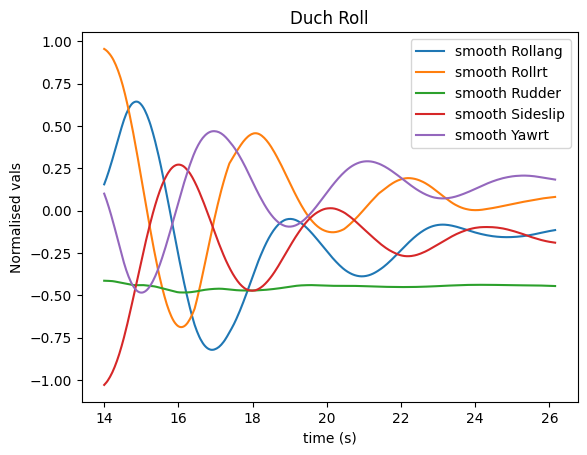

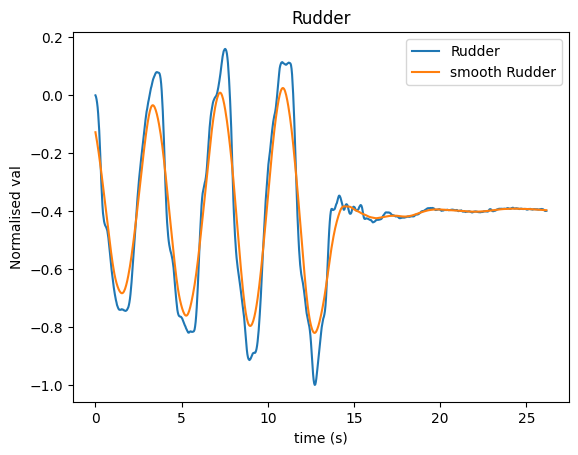

In [4]:
plot_all(duch_roll_data, start = 14)
plot_one(duch_roll_data, 'Rudder')

start = 14

def guess(data, key, start=0, end=None, debug=False, x_range=0.5):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    freq_out = freq_analysis(data, key, start=start,end=end, show=debug, debug=debug, plot=debug, x_range=x_range)
    if debug: print(freq_out)

    data_n = data[key][start_i:end_i].flatten()

    B = np.mean(gauss_smooth(data_n)) #/(t[-1]-14)*(t[1]-t[0])
    if debug: print(B)

    # B-=s1.3

    peaks = signal.find_peaks(gauss_smooth(data_n, window_size=30))[0]
    peaks_neg = signal.find_peaks(-gauss_smooth(data_n, window_size=30))[0]

    valid_peak = peaks
    ng_valid_peak=peaks_neg
    # for i in range(peaks.shape[0]):
    #     if start <= t[peaks_neg[i]] <= end: valid_peak.append(peaks[i])

    # ng_valid_peak = []
    # for i in range(peaks_neg.shape[0]):
    #     if start <= t[peaks_neg[i]] <= end: ng_valid_peak.append(peaks_neg[i])
    # valid_peak.sort()
    # valid_peak = np.array(valid_peak[:])
    # print(duch_roll_data["Rollang"][valid_peak])
    # plt.yscale("log")
    # print(t.flatten().shape)
    coef = np.polyfit(t[valid_peak].flatten(), np.log(data[key][valid_peak].flatten()), deg=1)
    func = np.poly1d(coef)

    p0 = [B, data[key][min(valid_peak[0], abs(ng_valid_peak[0]))], 1/freq_out, -coef[0]/(freq_out*2*np.pi)]

    if debug:
        plt.plot(t, secondOrd(start,*p0,t), label="simulated")
        plt.legend()
        plt.show()

    if debug:
        plt.plot(t[valid_peak], np.log(data[key][valid_peak]), 'x')
        plt.plot(t, func(t))
        plt.show()


    print(f"peak={coef[1]}, 1/tau = {coef[0]}")
    print(f"first peak = {data[key][valid_peak[0]]}")
    return p0

def exp_decay(t, B, A, tau, t0):
    y = B + A*(1-np.exp(-(t-t0)/tau))
    y[t<t0] = B
    return y

def func(t, B, A, freq, phi, one_over_tau):
    return B + A*np.exp(-t*one_over_tau)*np.sin(2*np.pi*freq*t + phi)

# B, A, freq, phi, 1/tau
# p0 = np.array([B, coef[1], freq_out, 0, -coef[0]])
# tol = 1e-3
# popt, pcov = curve_fit(func, t[t>14], duch_roll_data["Rollang"][t>14], p0, bounds=[[-np.inf, 0, freq_out-tol, -np.pi, 0], [np.inf, 100, freq_out+tol, np.pi, np.inf]])
# popt
# secondOrd(14,-0.3361946354689098-1.3,7.716,1/freq_out,0.4124759024598722//(freq_out*2*np.pi,t[t>14])





In [5]:
p0 = list(guess(duch_roll_data, "Rollang", start=14, debug=False))

def trial_and_error(B, peak, period, zeta):
    p= [B, peak, period, zeta]
    plot_one(duch_roll_data, "Rollang", show=False, start=14, norm=False)
    plot_guess(duch_roll_data, "Rollang", p, start=14)

p0[0]=-1.71
p0[1]=5.8
# p0[2]=4.04
p0[3]=0.222


B = widgets.FloatSlider(value=p0[0], min=-5, max=5, step=0.01)
peak = widgets.FloatSlider(value=p0[1], min=0, max=10, step=0.1)
period = widgets.FloatSlider(value=p0[2])
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
print(p0[3])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta)

peak=nan, 1/tau = nan
first peak = [-1.0414]
0.222


/var/folders/1s/6_5p_dbs6dd6_sw0f_l4nt940000gs/T/ipykernel_995/1959640832.py:43: RuntimeWarning: invalid value encountered in log
  coef = np.polyfit(t[valid_peak].flatten(), np.log(data[key][valid_peak].flatten()), deg=1)


interactive(children=(FloatSlider(value=-1.71, description='B', max=5.0, min=-5.0, step=0.01), FloatSlider(val…

<function __main__.trial_and_error(B, peak, period, zeta)>

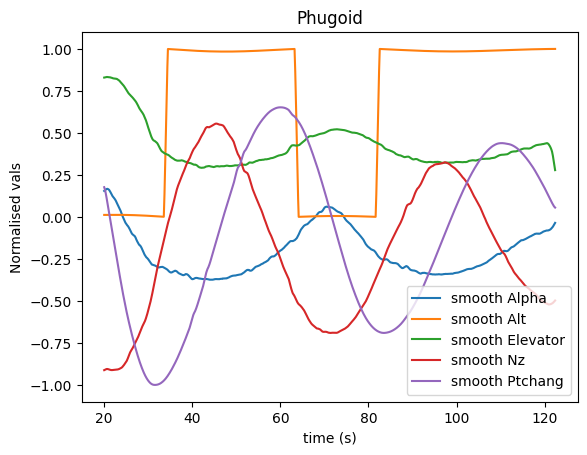

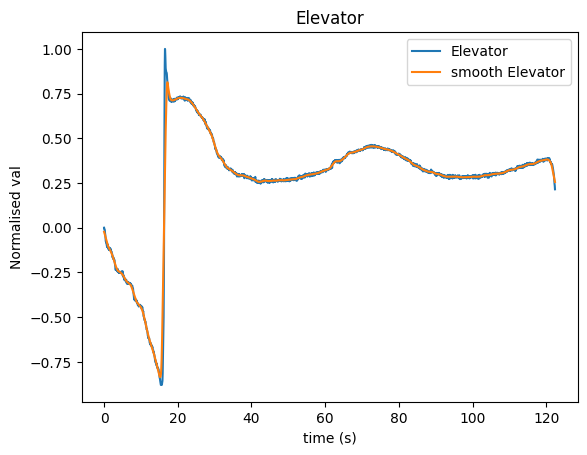

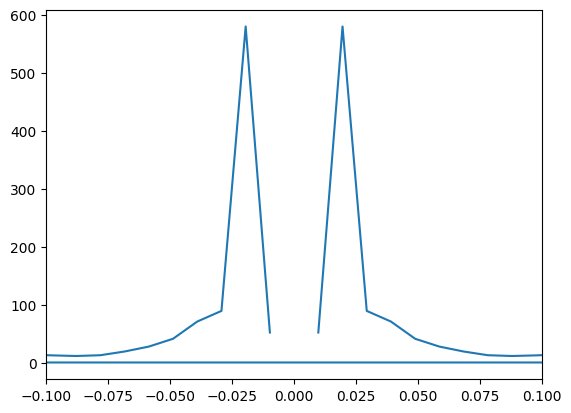

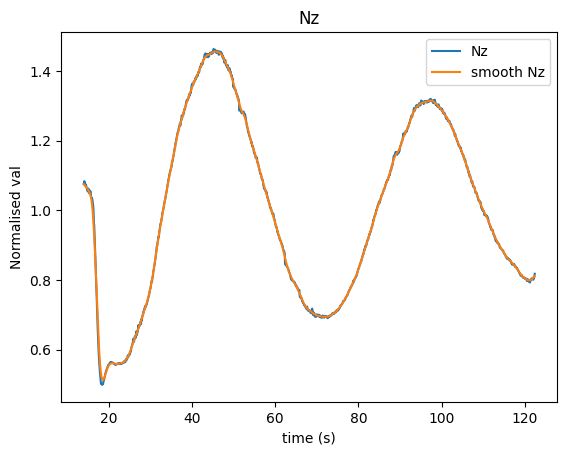

0.019530057979859627


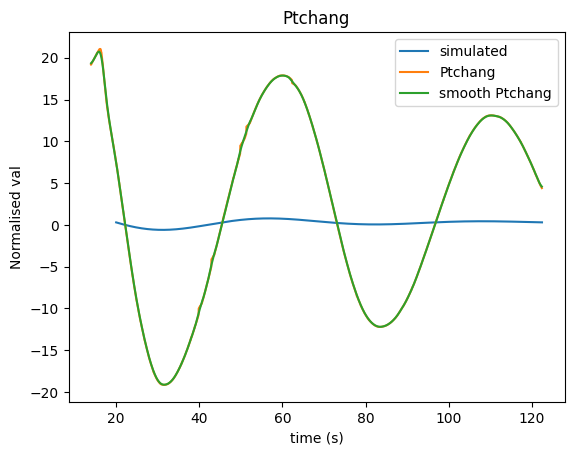

np.float64(0.019530057979859627)

In [6]:
plot_all(phugoid_data, start=20)
plot_one(phugoid_data, "Elevator")

t=phugoid_data["Time"]
freq_out = freq_analysis(phugoid_data, "Nz", start=20, debug=True, x_range=0.1)
print(freq_out)
plt.plot(t[t>20], -secondOrd(20,-0.3,0.6,1/freq_out,0.2,t[t>20]), label="simulated")

plt.legend()



freq_analysis(phugoid_data, "Ptchang", start=20)

In [22]:
data = phugoid_data
key = "Ptchang"
start = 20

p0 = list(guess(data, key, start=start, debug=False))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, norm=False)
    plot_guess(data, key, p,phi=phi, start=start)

p0[0]=1.43
p0[1]=19.40
# p0[2]=52.45
p0[3]=0.07
phi=-0.05

B = widgets.FloatSlider(value=p0[0], min=-5, max=5, step=0.01)
peak = widgets.FloatSlider(value=-p0[1], min=-100, max=0, step=0.1)
period = widgets.FloatSlider(value=p0[2], step=0.001)
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
phi=widgets.FloatSlider(value=phi, min=-np.pi, max=np.pi, step=0.01)
print(p0[2])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)

peak_method(phugoid_data, "Ptchang", start=start, end=None)

peak=nan, 1/tau = nan
first peak = [-9.8558]
51.203125


/var/folders/1s/6_5p_dbs6dd6_sw0f_l4nt940000gs/T/ipykernel_995/1959640832.py:43: RuntimeWarning: invalid value encountered in log
  coef = np.polyfit(t[valid_peak].flatten(), np.log(data[key][valid_peak].flatten()), deg=1)


interactive(children=(FloatSlider(value=1.43, description='B', max=5.0, min=-5.0, step=0.01), FloatSlider(valu…

(np.float64(0.06034343410717774), np.float64(52.458333333333336))

In [ ]:
data = phugoid_data
key = "Nz"
start = 20

p0 = list(guess(data, key, start=start, debug=False))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, norm=False, sigma=1, window=100)
    plot_guess(data, key, p,phi=phi, start=start)

p0[0]=1.02
p0[1]=0.56
# # p0[2]=51.2
p0[3]=0.06

phi=1.52

B = widgets.FloatSlider(value=p0[0], min=-5, max=5, step=0.01)
peak = widgets.FloatSlider(value=p0[1], min=0, max=2, step=0.01)
period = widgets.FloatSlider(value=p0[2], step=0.001)
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
print(p0[2])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)
peak_method(phugoid_data, "Nz", start=start, end=None, smooth_window_size=300, sigma=1)

peak=-0.08419031375755369, 1/tau = 0.0012039923723896802
first peak = [1.1303]
51.203125


interactive(children=(FloatSlider(value=1.02, description='B', max=5.0, min=-5.0, step=0.01), FloatSlider(valu…

(np.float64(0.06945839135928025), np.float64(51.8436999999999))

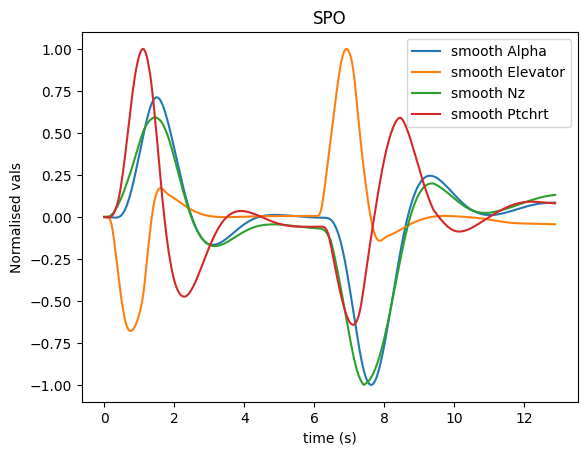

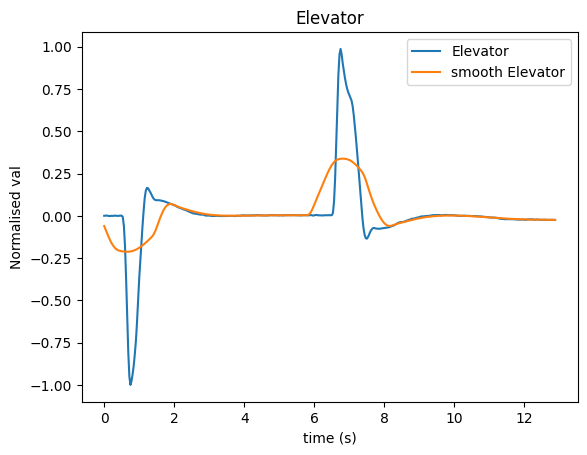

In [9]:
plot_all(SPO_data)
plot_one(SPO_data, "Elevator")

In [26]:
data = SPO_data
key = "Nz"
start = 9

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, norm=False, window=25, smooth=False)
    plot_guess(data, key, p,phi=phi, start=start)

p0[0]=1.04
p0[1]=1.12 # 1.12
p0[2]=3.60 # 3.81
p0[3]=0.19 # 0.23

phi=1.2 # 1.3

B = widgets.FloatSlider(value=p0[0], min=1, max=1.2, step=0.01)
peak = widgets.FloatSlider(value=p0[1], min=1, max=1.2, step=0.01)
period = widgets.FloatSlider(value=p0[2], min=2, max=4, step=0.001)
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
print(p0[2])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)

3.6


interactive(children=(FloatSlider(value=1.04, description='B', max=1.2, min=1.0, step=0.01), FloatSlider(value…

<function __main__.trial_and_error(B, peak, period, zeta, phi)>

In [ ]:
data = SPO_data
key = "Alpha"
start = 9

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, norm=False, window=25, smooth=False)
    plot_guess(data, key, p,phi=phi, start=start)

p0[0]=3.50 # 3.46
p0[1]=4.12 # 4.03
p0[2]=3.57 # 3.89
p0[3]=0.36 # 0.41

phi=0.89

B = widgets.FloatSlider(value=p0[0], min=3, max=4.5, step=0.01)
peak = widgets.FloatSlider(value=p0[1], min=3, max=4.5, step=0.01)
period = widgets.FloatSlider(value=p0[2], min=0, max=10, step=0.001)
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
print(p0[2])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)

3.57


interactive(children=(FloatSlider(value=3.5, description='B', max=4.5, min=3.0, step=0.01), FloatSlider(value=…

<function __main__.trial_and_error(B, peak, period, zeta, phi)>

In [ ]:
data = SPO_data
key = "Alpha"
start = 2
end=6

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=25, smooth=False)
    plot_guess(data, key, p,phi=phi, start=start, end=end)

p0[0]=3.18 # 3.46
p0[1]=4.37 # 4.03
p0[2]=3.65 # 3.89
p0[3]=0.51 # 0.41

phi=2.41

B = widgets.FloatSlider(value=p0[0], min=3, max=4.5, step=0.01)
peak = widgets.FloatSlider(value=p0[1], min=3, max=5, step=0.01)
period = widgets.FloatSlider(value=p0[2], min=0, max=10, step=0.001)
zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
print(p0[2])

interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)

3.65


interactive(children=(FloatSlider(value=3.18, description='B', max=4.5, min=3.0, step=0.01), FloatSlider(value…

<function __main__.trial_and_error(B, peak, period, zeta, phi)>

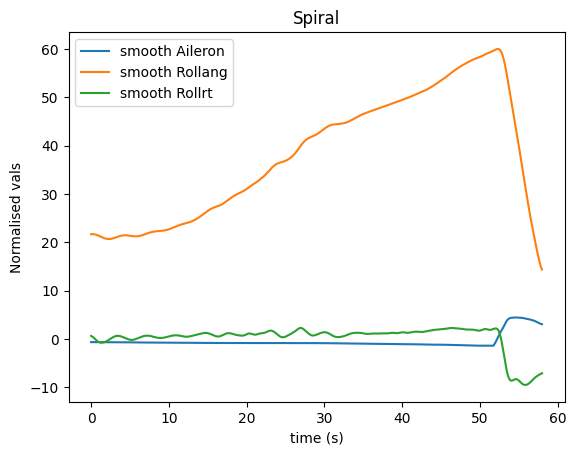

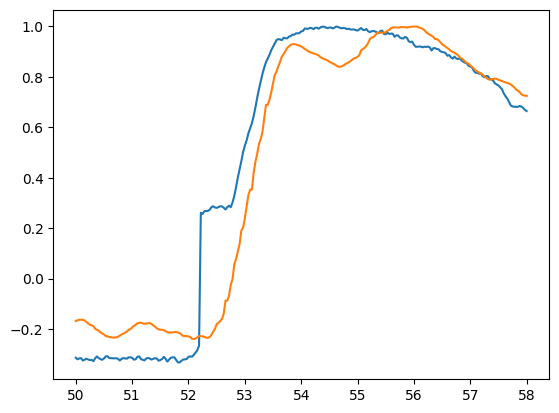

In [62]:
plot_all(spiral_data, start=0, norm=False)
# plot_one(spiral_data, "Aileron", start=0, end=None)
# plot_one(spiral_data, "Rollrt", start=0, end=None)
# freq_out = freq_analysis(spiral_data, "Rollrt", start=0, end=30, debug=True, x_range=0.4)
# freq_out

start = 50
end = None

t_true = data['Time']
if end is None : end = t_true[-1]
try:
    start_i = np.where(start <= t_true)[0][0]
    end_i = np.where(t_true <= end)[0][-1]
except IndexError:
    print("Invalid start or end")

t = t_true[start_i:end_i].flatten()

Aileron = spiral_data["Aileron"][start_i:end_i].flatten()
Rollrt = spiral_data["Rollrt"][start_i:end_i].flatten()

plt.plot(t, Aileron/np.max(Aileron))
plt.plot(t, -Rollrt/np.max(-Rollrt))
plt.show()

In [ ]:
import scipy.integrate


plot_all(spiral_data, start=0, norm=False)
start = 0
end = 50
plot_one(data, key, show=False, start=start, end=end, norm=False, window=200)
# plot_guess(data, key, p,phi=phi, start=start, end=end)
t_true = data['Time']
if end is None : end = t_true[-1]
try:
    start_i = np.where(start <= t_true)[0][0]
    end_i = np.where(t_true <= end)[0][-1]
except IndexError:
    print("Invalid start or end")

t = t_true[start_i:end_i].flatten()
u_n = -gauss_smooth(spiral_data["Aileron"][start_i:end_i].flatten(), window_size=200, sigma=0.1)
y_np = spiral_data["Rollang"][start_i:end_i].flatten()
y_np2 = spiral_data["Rollrt"][start_i:end_i].flatten()


y_n = np.zeros_like(u_n)
Ts = np.mean(np.diff(t))

def trial_and_error(tau, A, B):
    y_n[:2] = y_np2[:2]
    k = (Ts)/(2*tau)

    kernel = np.zeros_like(u_n)

    for i in range(y_n.shape[0]-2):
        y_n[i+2] = 1/(k+1)*((2*A/Ts)*(u_n[i+2]-2*u_n[i+1]+u_n[i])- 2*k*y_n[i+1] - (k-1)*y_n[i])

    # for i in range(y_n.shape[0]):
    #     kernel[i] = (2*(k**2)*(((1-k)/(k+1))**i)-2*(k*k-1)*np.exp(1j*np.pi*i)) / (1-k*k)

    # y_n[:s] = np.convolve(kernel, u_n, mode="same")
    y_n2 = scipy.integrate.cumulative_simpson(y_n, x=t) + B


    plt.plot(t, y_n)
    plt.plot(t, u_n)
    plt.plot(t, kernel)
    plt.plot(t, y_np)
    plt.plot(t[:-1], y_n2)
    plt.show()

tau = 1000
A = 1

B = widgets.FloatSlider(value=20, min=15, max=25, step=0.01)
A = widgets.FloatSlider(value=A, min=1, max=500, step=0.01)
tau = widgets.FloatSlider(value=tau, min=0, max=100, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=0, max=5, step=0.01)
print(p0[2])

interact(trial_and_error, A=A, tau=tau, B=B)

s0 = 19.45540690330415 	 tau = 42.33675834529158


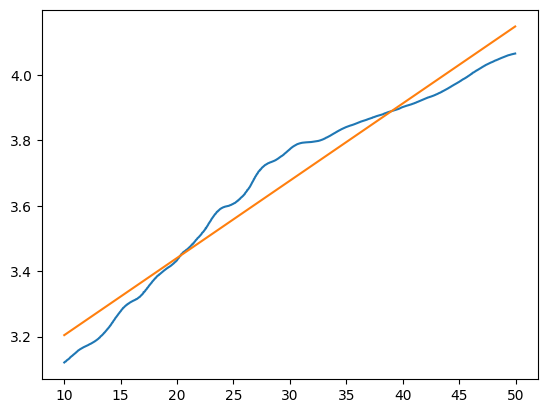

3.7593984962406015


interactive(children=(FloatSlider(value=15.81, description='B', max=25.0, min=15.0, step=0.01), FloatSlider(va…

<function __main__.trial_and_error(B, A, tau, t0)>

In [66]:
# this is just wrong
data = spiral_data
key = "Rollang"
start = 10
end = 50

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def exp_growth(t, B, A, tau, t0):
    y = B + A*(np.exp((t-t0)/tau)-1)
    # y[t<t0] = B
    return y

def trial_and_error(B, A, tau, t0):
    start = 10
    end = 50
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=200, smooth=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_growth(t,B, A, tau, t0))
    # plt.ylim(0, 6.5)
    plt.show()

t_true = data['Time']
if end is None : end = t_true[-1]
try:
    start_i = np.where(start <= t_true)[0][0]
    end_i = np.where(t_true <= end)[0][-1]
except IndexError:
    print("Invalid start or end")
t = t_true[start_i:end_i].flatten()
data_n =data[key][start_i:end_i].flatten()
smoothed_data_n = gauss_smooth(data_n, window_size=200)
# data_n -= data_n[0] +1

coef = np.polyfit(t, np.log(data_n), deg=1)
func = np.poly1d(coef)

print(f"s0 = {np.exp(coef[-1])} \t tau = {1/coef[0]}")

plt.plot(t, np.log(data_n))
# plt.plot(t, np.log(smoothed_data_n))
plt.plot(t, func(t))
plt.show()

B = 15.81 # 16.45
A = 15.844062538182085   # 15.844062538182085 # 19.298398640851886 # 16.108573013976965 
tau = 29.39553867412161 # 27.16 # 42.000699147756045 # 29.39553867412161 # 42.000699147756045 # 30.08815638051047
t0 = 0

B = widgets.FloatSlider(value=B, min=15, max=25, step=0.01)
A = widgets.FloatSlider(value=A, min=1, max=25, step=0.01)
tau = widgets.FloatSlider(value=tau, min=10, max=40, step=0.001)
t0 = widgets.FloatSlider(value=t0, min=0, max=10, step=0.01)
print(p0[2])

interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)

s0 = 315008022.98889065 	 tau = -3.4494833257993855


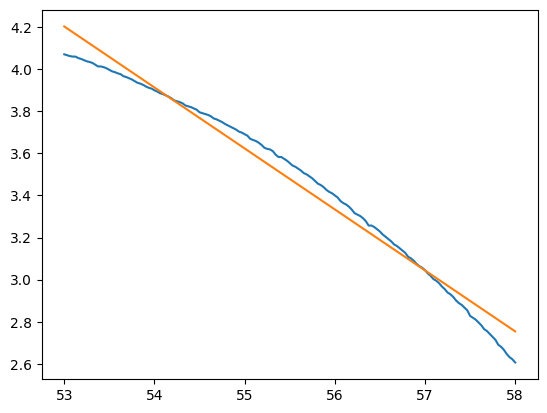

interactive(children=(FloatSlider(value=60.0, description='B', max=70.0, min=50.0, step=0.01), FloatSlider(val…

<function __main__.trial_and_error(B, A, tau, t0)>

In [ ]:
data = spiral_data
key = "Rollang"
start = 53
end=None

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    p= [B, peak, period, zeta]
    start = 53
    end=None
    plot_one(data, key, show=False, start=start, end=end, norm=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(0, 6.5)
    plt.show()

t_true = data['Time']
if end is None : end = t_true[-1]
try:
    start_i = np.where(start <= t_true)[0][0]
    end_i = np.where(t_true <= end)[0][-1]
except IndexError:
    print("Invalid start or end")
t = t_true[start_i:end_i].flatten()
data_n =data[key][start_i:end_i].flatten()
smoothed_data_n = gauss_smooth(data_n, window_size=200)
# data_n -= data_n[0] +1

coef = np.polyfit(t, np.log(data_n), deg=1)
func = np.poly1d(coef)

print(f"s0 = {np.exp(coef[-1])} \t tau = {1/coef[0]}")

plt.plot(t, np.log(data_n))
# plt.plot(t, np.log(smoothed_data_n))
plt.plot(t, func(t))
plt.show()

B = 60
A = 10
tau = -3.4494833257993855
t0 = 53

B = widgets.FloatSlider(value=B, min=50, max=70, step=0.01)
A = widgets.FloatSlider(value=A, min=0, max=100, step=0.01)
tau = widgets.FloatSlider(value=tau, min=-10, max=0, step=0.001)
t0 = widgets.FloatSlider(value=t0, min=53, max=55, step=0.01)

interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)

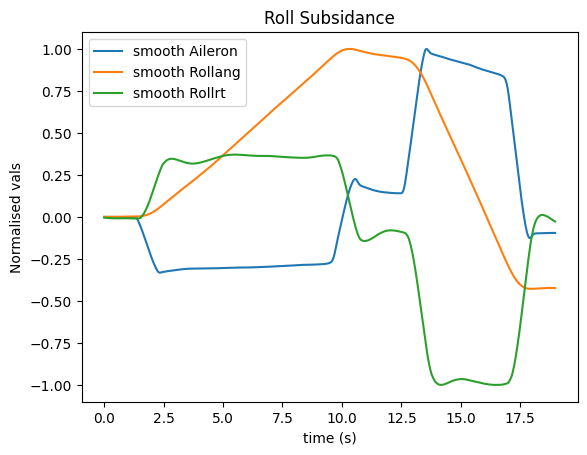

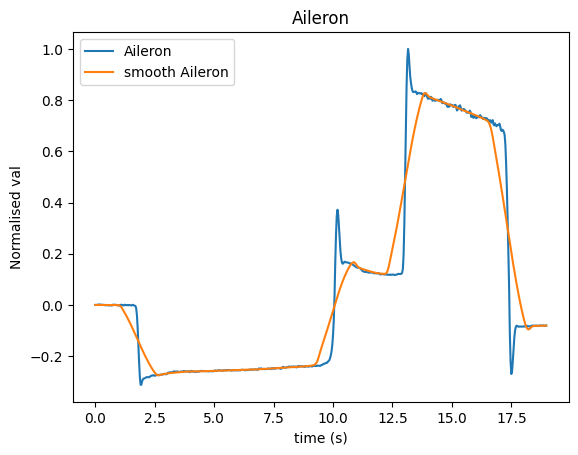

In [41]:
plot_all(roll_rub_data)
plot_one(roll_rub_data, "Aileron")

In [19]:
data = roll_rub_data
key = "Rollrt"

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 0
    end = 10
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    plt.ylim(0, 6.5)
    plt.show()

B = 0.2
A = 5.72
tau = 0.30
t0 = 1.81

B = widgets.FloatSlider(value=B, min=0, max=6, step=0.01)
A = widgets.FloatSlider(value=A, min=1, max=6, step=0.01)
tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
t0 = widgets.FloatSlider(value=t0, min=-2, max=2, step=0.01)
print(p0[2])

interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)

3.7593984962406015


interactive(children=(FloatSlider(value=0.2, description='B', max=6.0, step=0.01), FloatSlider(value=5.72, des…

<function __main__.trial_and_error(B, A, tau, t0)>

In [20]:
data = roll_rub_data
key = "Rollrt"
start = 12.5
end = None

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 12.5
    end = None
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(, 6.5)
    plt.show()

B = -1.17
A = -13.95
tau = 0.25
t0 = 13.05

B = widgets.FloatSlider(value=B, min=-15, max=0, step=0.01)
A = widgets.FloatSlider(value=A, min=-15, max=0, step=0.01)
tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
t0 = widgets.FloatSlider(value=t0, min=12, max=14, step=0.01)
print(p0[2])

interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)

3.7593984962406015


interactive(children=(FloatSlider(value=-1.17, description='B', max=0.0, min=-15.0, step=0.01), FloatSlider(va…

<function __main__.trial_and_error(B, A, tau, t0)>

In [63]:
data = roll_rub_data
key = "Rollrt"
start = 5
end = 12.5

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 5
    end = 12.5
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(0, 6.5)
    plt.show()

B = 6
A = -5.72
tau = 0.30
t0 = 10

B = widgets.FloatSlider(value=B, min=5, max=7, step=0.01)
A = widgets.FloatSlider(value=A, min=-10, max=0, step=0.01)
tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
t0 = widgets.FloatSlider(value=t0, min=10, max=11, step=0.01)
print(p0[2])

interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)

3.7593984962406015


interactive(children=(FloatSlider(value=6.0, description='B', max=7.0, min=5.0, step=0.01), FloatSlider(value=…

<function __main__.trial_and_error(B, A, tau, t0)>

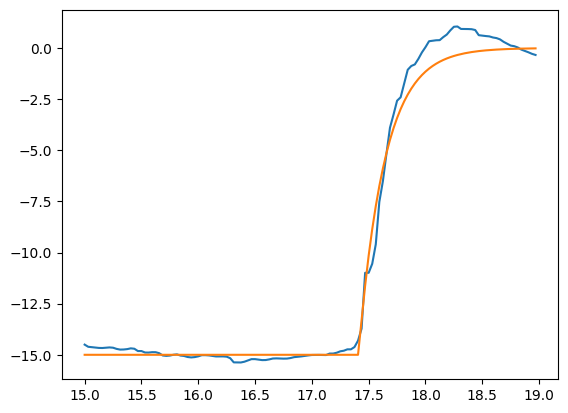

In [68]:
data = roll_rub_data
key = "Rollrt"
start = 15
end = None

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 15
    end = None
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20, smooth=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(, 6.5)
    plt.show()

B = -15
A = 15
tau = 0.23
t0 = 17.41

# B = widgets.FloatSlider(value=B, min=-15, max=0, step=0.01)
# A = widgets.FloatSlider(value=A, min=0, max=15, step=0.01)
# tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=17, max=18, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)
trial_and_error(B, A, tau, t0)